In [1]:
#https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic/notebook

In [82]:
import pandas as pd
from pandas import Series, DataFrame

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [83]:
titanic_df = pd.read_csv('train.csv', dtype={'Age':np.float64})
test_df = pd.read_csv('test.csv', dtype={'Age':np.float64})

titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [84]:
titanic_df = titanic_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
test_df = test_df.drop(['Name', 'Ticket'], axis = 1)

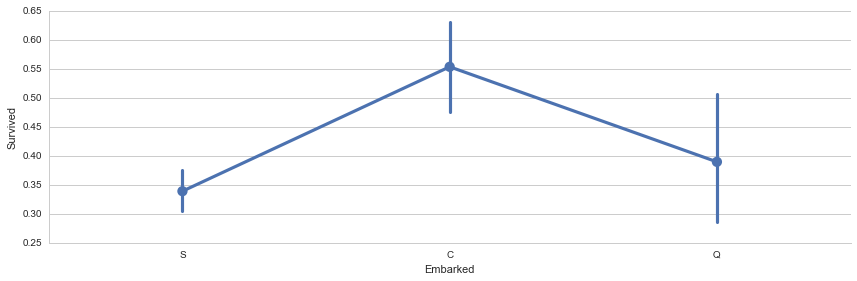

In [85]:
titanic_df['Embarked'] = titanic_df['Embarked'].fillna("S")
sns.factorplot('Embarked', 'Survived', data = titanic_df, size = 4, aspect = 3)

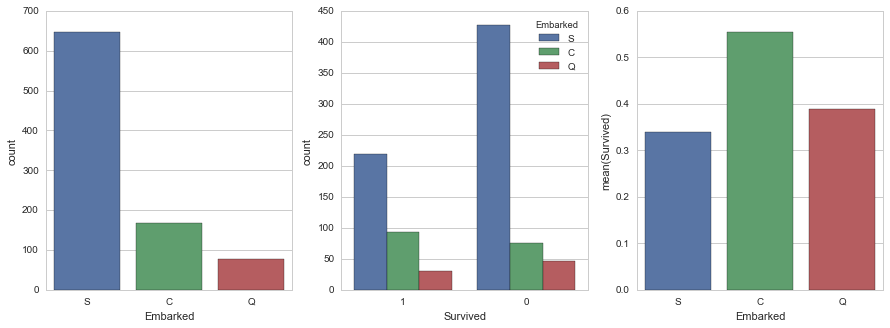

In [86]:
fig, (axis1, axis2, axis3) = plt.subplots(1,3,figsize=(15,5))

sns.countplot(x='Embarked', data = titanic_df, ax = axis1)
sns.countplot(x='Survived', hue = 'Embarked', data=titanic_df, order=[1,0],ax = axis2)

embark_perc = titanic_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index = False).mean()
sns.barplot(x='Embarked', y = 'Survived', data=embark_perc, order=['S', 'C', 'Q'], ax = axis3)

In [87]:
# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_titanic = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)
titanic_df = titanic_df.join(embark_dummies_titanic)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)
test_df = test_df.join(embark_dummies_test)

titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1, inplace=True)

In [88]:
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

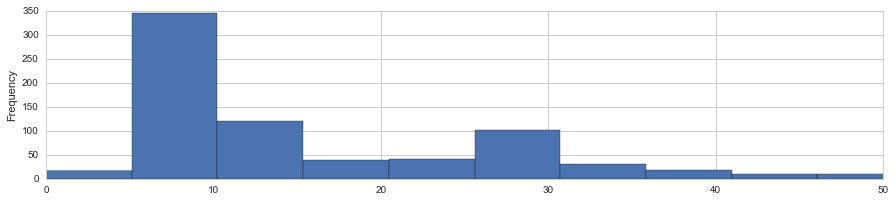

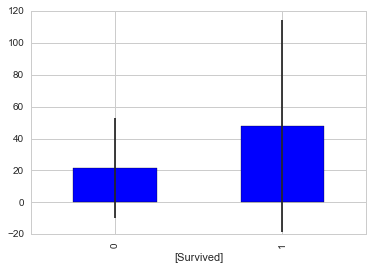

In [89]:
titanic_df['Fare']=titanic_df['Fare'].astype(int)
test_df['Fare']=test_df['Fare'].astype(int)

fare_not_survived = titanic_df['Fare'][titanic_df['Survived']==0]
fare_survived = titanic_df['Fare'][titanic_df['Survived']==1]

average_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare = DataFrame([fare_not_survived.std(), fare_survived.std()])

titanic_df['Fare'].plot(kind='hist', figsize=(15,3),bins=100, xlim=(0,50))

average_fare.index.name = std_fare.index.name = ['Survived']
average_fare.plot(yerr=std_fare,kind='bar',legend=False)

/Users/ethan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ethan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


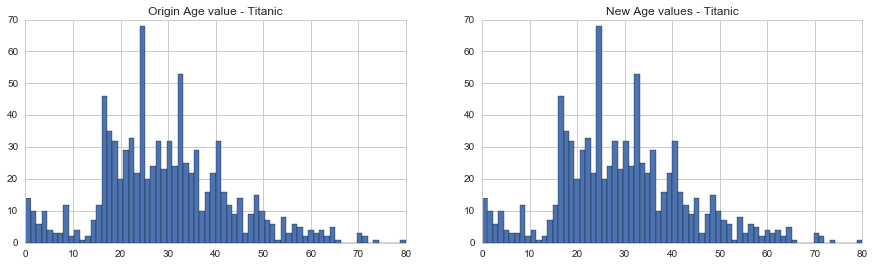

In [90]:
fig, (axis1, axis2)=plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Origin Age value - Titanic')
axis2.set_title('New Age values - Titanic')

average_age_titanic = titanic_df['Age'].mean()
std_age_titanic = titanic_df['Age'].std()
count_nan_age_titanic = titanic_df['Age'].isnull().sum()

average_age_test = test_df['Age'].mean()
std_age_test = test_df['Age'].std()
count_nan_age_test = test_df['Age'].isnull().sum()

rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic+std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test+std_age_test, size = count_nan_age_test)

titanic_df['Age'][np.isnan(titanic_df['Age'])] = rand_1
test_df['Age'][np.isnan(test_df['Age'])] = rand_2

titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age'] = test_df['Age'].astype(int)

titanic_df['Age'].hist(bins=70, ax=axis1)
titanic_df['Age'].hist(bins=70, ax=axis2)

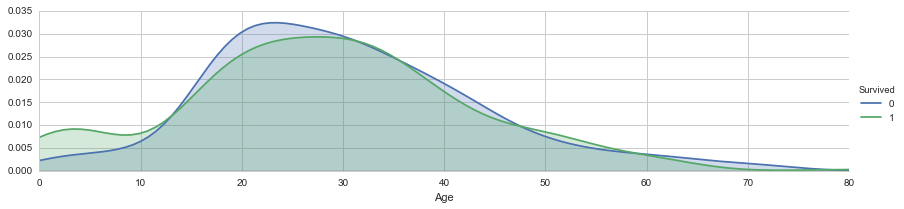

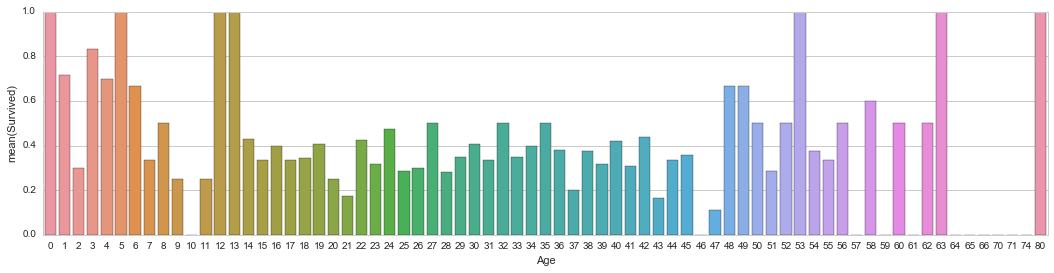

In [91]:
facet = sns.FacetGrid(titanic_df, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0,titanic_df['Age'].max()))
facet.add_legend()

fig,axis1 = plt.subplots(1,1,figsize=(18,4))
average_age=titanic_df[['Age', 'Survived']].groupby(['Age'], as_index=False).mean()
sns.barplot(x='Age', y = 'Survived', data=average_age)

In [92]:
titanic_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

In [93]:
titanic_df['Family'] = titanic_df['Parch']+titanic_df['SibSp']
titanic_df['Family'].loc[titanic_df['Family']>0] = 1
titanic_df['Family'].loc[titanic_df['Family']==0] = 0

test_df['Family'] = test_df['Parch']+test_df['SibSp']
test_df['Family'].loc[test_df['Family']>0] = 1
test_df['Family'].loc[test_df['Family']==0] = 0

titanic_df = titanic_df.drop(['SibSp', 'Parch'], axis=1)
test_df = test_df.drop(['SibSp', 'Parch'], axis=1)

[<matplotlib.text.Text at 0x10c333950>, <matplotlib.text.Text at 0x11477ad10>]

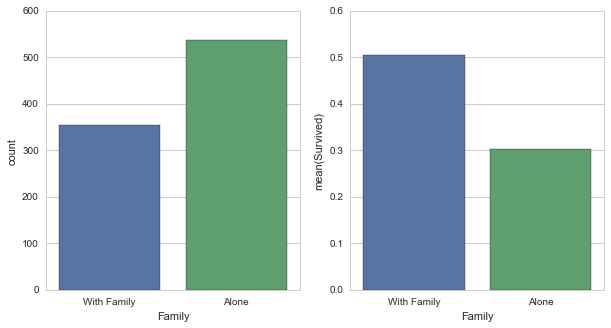

In [94]:
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,5))

sns.countplot(x='Family', data=titanic_df,order=[1,0], ax= axis1)

family_perc = titanic_df[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()
sns.barplot('Family','Survived', data=family_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(['With Family', 'Alone'], rotation=0)

In [95]:
def get_person(passenger):
    age, sex = passenger
    return 'child' if age < 16 else sex

titanic_df['Person'] = titanic_df[['Age', 'Sex']].apply(get_person, axis=1)
test_df['Person'] = test_df[['Age', 'Sex']].apply(get_person, axis=1)

titanic_df.drop(['Sex'], axis =1, inplace=True)
test_df.drop(['Sex'], axis =1, inplace=True)

In [96]:
person_dummis_titanic = pd.get_dummies(titanic_df['Person'])
person_dummis_titanic.columns = ['Male', 'Female', 'Child']
person_dummis_titanic.drop(['Male'], axis = 1, inplace=True)

person_dummis_test = pd.get_dummies(test_df['Person'])
person_dummis_test.columns = ['Male', 'Female', 'Child']
person_dummis_test.drop(['Male'], axis = 1, inplace=True)

titanic_df = titanic_df.join(person_dummis_titanic)
test_df = test_df.join(person_dummis_test)

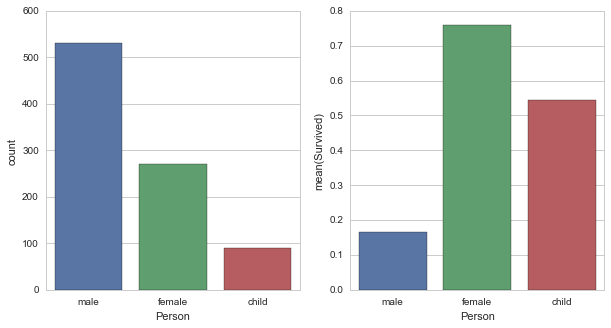

In [97]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(10,5))

sns.countplot(x='Person', data=titanic_df, ax = axis1)

family_perc = titanic_df[['Person', 'Survived']].groupby(['Person'], as_index=False).mean()
sns.barplot('Person', 'Survived', data=family_perc, ax=axis2, order=['male', 'female', 'child'])

In [98]:
titanic_df.drop(['Person'], axis=1, inplace=True)
test_df.drop(['Person'], axis=1, inplace=True)

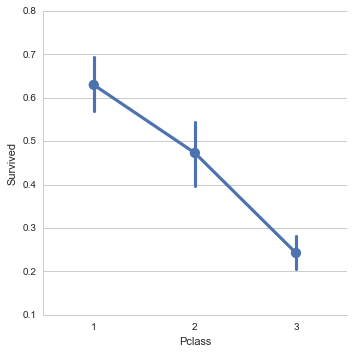

In [99]:
sns.factorplot('Pclass', 'Survived', order=[1, 2, 3], data= titanic_df, size =5)

In [100]:
pclass_dummies_titanic = pd.get_dummies(titanic_df['Pclass'])
pclass_dummies_titanic.columns=['Class_1', 'Class_2', 'Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis =1, inplace = True)

pclass_dummies_test = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns=['Class_1', 'Class_2', 'Class_3']
pclass_dummies_test.drop(['Class_3'], axis =1, inplace = True)

titanic_df.join(pclass_dummies_titanic)
test_df.join(pclass_dummies_test)

titanic_df.drop(['Pclass'], axis=1, inplace=True)
test_df.drop(['Pclass'], axis=1, inplace=True)

In [101]:
X_train = titanic_df.drop(['Survived'], axis=1)
Y_train = titanic_df['Survived']
X_test = test_df.drop(['PassengerId'], axis=1).copy()

In [102]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred_rf = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)

0.96632996632996637

In [103]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred_knn = knn.predict(X_test)
knn.score(X_train, Y_train)

0.82603815937149272

In [104]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred_gau = gaussian.predict(X_test)
gaussian.score(X_train, Y_train)

0.78338945005611671

In [105]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred_lr = logreg.predict(X_test)
logreg.score(X_train, Y_train)

0.77553310886644222

In [80]:
#Y_pred = Y_pred_rf + Y_pred_lr + Y_pred_gau
#submission = pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':Y_pred})
#submission['Survived'].loc[submission['Survived']<2]=0
#submission['Survived'].loc[submission['Survived']>=2]=1
#submission

In [81]:
submission = pd.DataFrame({"PassengerId": test_df["PassengerId"],"Survived": Y_pred_lr})
submission.to_csv('lr2.csv', index=False)